## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\benja\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [18]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [{'name': 'SGD', 'optim': keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)},
                 {'name':'Adam', 'optim': keras.optimizers.Adam(lr=LEARNING_RATE)},
                 {'name': 'RMS', 'optim': keras.optimizers.RMSprop(lr=LEARNING_RATE)}]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.05, 0.1, 0.5]
redice_lr_patient = [5, 10, 25]

In [23]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print(optim['name'],reduce_factor, reduce_patient)
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim['optim'])
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = "{}, {}, {}".format(optim['name'], reduce_factor, reduce_patient)
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

SGD 0.05 5
Numbers of exp: 0, reduce_factor: 0.05, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_n

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 230us/step - loss: 2.2670 - acc: 0.2548 - val_loss: 2.1796 - val_acc: 0.2994
Epoch 2/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.7804 - acc: 0.3779 - val_loss: 1.8829 - val_acc: 0.3611
Epoch 3/25
50000/50000 [==============================] - 9s 188us/step - loss: 1.6494 - acc: 0.4208 - val_loss: 1.7287 - val_acc: 0.3945
Epoch 4/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.5743 - acc: 0.4472 - val_loss: 1.6757 - val_acc: 0.4114
Epoch 5/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.5186 - acc: 0.4681 - val_loss: 1.6267 - val_acc: 0.4277
Epoch 6/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.4728 - acc: 0.4821 - val_loss: 1.6108 - val_acc: 0.4307
Epoch 7/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.4353 - acc: 0.4954 - val_loss: 1.5643 -

50000/50000 [==============================] - 15s 308us/step - loss: 1.3433 - acc: 0.5306 - val_loss: 1.5045 - val_acc: 0.4729
Epoch 11/25
50000/50000 [==============================] - 13s 264us/step - loss: 1.3186 - acc: 0.5387 - val_loss: 1.4918 - val_acc: 0.4803
Epoch 12/25
50000/50000 [==============================] - 12s 248us/step - loss: 1.2939 - acc: 0.5478 - val_loss: 1.4877 - val_acc: 0.4791
Epoch 13/25
50000/50000 [==============================] - 12s 245us/step - loss: 1.2714 - acc: 0.5566 - val_loss: 1.4796 - val_acc: 0.4815
Epoch 14/25
50000/50000 [==============================] - 13s 266us/step - loss: 1.2493 - acc: 0.5637 - val_loss: 1.4782 - val_acc: 0.4846
Epoch 15/25
50000/50000 [==============================] - 12s 249us/step - loss: 1.2314 - acc: 0.5717 - val_loss: 1.4722 - val_acc: 0.4883
Epoch 16/25
50000/50000 [==============================] - 13s 252us/step - loss: 1.2108 - acc: 0.5797 - val_loss: 1.4622 - val_acc: 0.4950
Epoch 17/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 277us/step - loss: 2.2446 - acc: 0.2629 - val_loss: 2.1821 - val_acc: 0.3085
Epoch 2/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.7703 - acc: 0.3827 - val_loss: 1.8462 - val_acc: 0.3729
Epoch 3/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.6405 - acc: 0.4242 - val_loss: 1.7164 - val_acc: 0.4015
Epoch 4/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.5698 - acc: 0.4489 - val_loss: 1.6411 - val_acc: 0.4239
Epoch 5/25
50000/50000 [==============================] - 13s 251us/step - loss: 1.5133 - acc: 0.4678 - val_loss: 1.6106 - val_acc: 0.4331
Epoch 6/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.4693 - acc: 0.4857 - val_loss: 1.5894 - val_acc: 0.4392
Epoch 7/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.4343 - acc: 0.4962 - val_loss: 1.

Epoch 23/25
50000/50000 [==============================] - 9s 190us/step - loss: 0.5223 - acc: 0.8434 - val_loss: 1.3923 - val_acc: 0.5468
Epoch 24/25
50000/50000 [==============================] - 10s 192us/step - loss: 0.5161 - acc: 0.8469 - val_loss: 1.3866 - val_acc: 0.5479

Epoch 00024: ReduceLROnPlateau reducing learning rate to 2.5000001187436284e-06.
Epoch 25/25
50000/50000 [==============================] - 10s 198us/step - loss: 0.5057 - acc: 0.8499 - val_loss: 1.3839 - val_acc: 0.5498
Adam 0.05 10
Numbers of exp: 10, reduce_factor: 0.05, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_55 (Batc (

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 285us/step - loss: 2.6394 - acc: 0.1682 - val_loss: 2.4578 - val_acc: 0.2162
Epoch 2/25
50000/50000 [==============================] - 9s 186us/step - loss: 2.2757 - acc: 0.2457 - val_loss: 2.2781 - val_acc: 0.2507
Epoch 3/25
50000/50000 [==============================] - 10s 192us/step - loss: 2.1575 - acc: 0.2753 - val_loss: 2.1814 - val_acc: 0.2717
Epoch 4/25
50000/50000 [==============================] - 9s 190us/step - loss: 2.0851 - acc: 0.2944 - val_loss: 2.1114 - val_acc: 0.2908
Epoch 5/25
50000/50000 [==============================] - 10s 191us/step - loss: 2.0331 - acc: 0.3082 - val_loss: 2.0649 - val_acc: 0.3022
Epoch 6/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.9936 - acc: 0.3202 - val_loss: 2.0319 - val_acc: 0.3116
Epoch 7/25
50000/50000 [==============================] - 9s 190us/step - loss: 1.9600 - acc: 0.3289 - val_loss: 2.0032

Epoch 24/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.6985 - acc: 0.4137 - val_loss: 1.7841 - val_acc: 0.3814
Epoch 25/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.6927 - acc: 0.4156 - val_loss: 1.7781 - val_acc: 0.3833
Adam 0.5 5
Numbers of exp: 15, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
__________________________________________________________

50000/50000 [==============================] - 14s 285us/step - loss: 1.8702 - acc: 0.3616 - val_loss: 1.9302 - val_acc: 0.3467
Epoch 12/25
50000/50000 [==============================] - 14s 282us/step - loss: 1.8537 - acc: 0.3661 - val_loss: 1.9155 - val_acc: 0.3503
Epoch 13/25
50000/50000 [==============================] - 14s 279us/step - loss: 1.8387 - acc: 0.3690 - val_loss: 1.9019 - val_acc: 0.3536
Epoch 14/25
50000/50000 [==============================] - 14s 276us/step - loss: 1.8245 - acc: 0.3731 - val_loss: 1.8911 - val_acc: 0.3555
Epoch 15/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.8115 - acc: 0.3781 - val_loss: 1.8791 - val_acc: 0.3583
Epoch 16/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.7990 - acc: 0.3825 - val_loss: 1.8694 - val_acc: 0.3616
Epoch 17/25
50000/50000 [==============================] - 14s 272us/step - loss: 1.7887 - acc: 0.3843 - val_loss: 1.8612 - val_acc: 0.3632
Epoch 18/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 20s 400us/step - loss: 1.8228 - acc: 0.3675 - val_loss: 2.5424 - val_acc: 0.2525
Epoch 2/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.5301 - acc: 0.4602 - val_loss: 2.3193 - val_acc: 0.2708
Epoch 3/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.4247 - acc: 0.4954 - val_loss: 1.8772 - val_acc: 0.3676
Epoch 4/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.3376 - acc: 0.5245 - val_loss: 2.8753 - val_acc: 0.2453
Epoch 5/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.2743 - acc: 0.5518 - val_loss: 1.7765 - val_acc: 0.3950
Epoch 6/25
50000/50000 [==============================] - 14s 273us/step - loss: 1.2124 - acc: 0.5718 - val_loss: 1.7068 - val_acc: 0.4317
Epoch 7/25
50000/50000 [==============================] - 14s 272us/step - loss: 1.1686 - acc: 0.5882 - val_loss: 1.

Epoch 23/25
50000/50000 [==============================] - 14s 274us/step - loss: 1.0940 - acc: 0.6260 - val_loss: 1.4834 - val_acc: 0.4841
Epoch 24/25
50000/50000 [==============================] - 14s 288us/step - loss: 1.0782 - acc: 0.6324 - val_loss: 1.4681 - val_acc: 0.4899
Epoch 25/25
50000/50000 [==============================] - 15s 296us/step - loss: 1.0637 - acc: 0.6389 - val_loss: 1.4742 - val_acc: 0.4891
RMS 0.05 25
Numbers of exp: 20, reduce_factor: 0.05, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_85 (Batc (None, 256)               1024      
______________________________________________

Epoch 10/25
50000/50000 [==============================] - 15s 299us/step - loss: 1.3541 - acc: 0.5289 - val_loss: 1.5534 - val_acc: 0.4567
Epoch 11/25
50000/50000 [==============================] - 14s 284us/step - loss: 1.3273 - acc: 0.5388 - val_loss: 1.5546 - val_acc: 0.4536
Epoch 12/25
50000/50000 [==============================] - 14s 273us/step - loss: 1.3016 - acc: 0.5488 - val_loss: 1.5299 - val_acc: 0.4653
Epoch 13/25
50000/50000 [==============================] - 14s 290us/step - loss: 1.2771 - acc: 0.5591 - val_loss: 1.5372 - val_acc: 0.4566
Epoch 14/25
50000/50000 [==============================] - 14s 285us/step - loss: 1.2551 - acc: 0.5667 - val_loss: 1.5672 - val_acc: 0.4515
Epoch 15/25
50000/50000 [==============================] - 15s 299us/step - loss: 1.2344 - acc: 0.5744 - val_loss: 1.5128 - val_acc: 0.4705
Epoch 16/25
50000/50000 [==============================] - 17s 336us/step - loss: 1.2144 - acc: 0.5820 - val_loss: 1.5208 - val_acc: 0.4635
Epoch 17/25
50000/50

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 21s 423us/step - loss: 2.1900 - acc: 0.2727 - val_loss: 2.1164 - val_acc: 0.3068
Epoch 2/25
50000/50000 [==============================] - 14s 274us/step - loss: 1.8324 - acc: 0.3623 - val_loss: 1.8976 - val_acc: 0.3560
Epoch 3/25
50000/50000 [==============================] - 14s 275us/step - loss: 1.7030 - acc: 0.4058 - val_loss: 1.8127 - val_acc: 0.3777
Epoch 4/25
50000/50000 [==============================] - 14s 287us/step - loss: 1.6191 - acc: 0.4342 - val_loss: 1.7495 - val_acc: 0.3956
Epoch 5/25
50000/50000 [==============================] - 15s 309us/step - loss: 1.5555 - acc: 0.4585 - val_loss: 1.6637 - val_acc: 0.4162
Epoch 6/25
50000/50000 [==============================] - 15s 298us/step - loss: 1.5051 - acc: 0.4747 - val_loss: 1.6723 - val_acc: 0.4142
Epoch 7/25
50000/50000 [==============================] - 14s 278us/step - loss: 1.4625 - acc: 0.4906 - val_loss: 1.

50000/50000 [==============================] - 14s 273us/step - loss: 1.3624 - acc: 0.5312 - val_loss: 1.5612 - val_acc: 0.4573
Epoch 11/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.3351 - acc: 0.5390 - val_loss: 1.5502 - val_acc: 0.4509
Epoch 12/25
50000/50000 [==============================] - 14s 276us/step - loss: 1.3096 - acc: 0.5481 - val_loss: 1.5383 - val_acc: 0.4629
Epoch 13/25
50000/50000 [==============================] - 14s 275us/step - loss: 1.2853 - acc: 0.5578 - val_loss: 1.5325 - val_acc: 0.4628
Epoch 14/25
50000/50000 [==============================] - 14s 274us/step - loss: 1.2631 - acc: 0.5648 - val_loss: 1.5075 - val_acc: 0.4745
Epoch 15/25
50000/50000 [==============================] - 14s 275us/step - loss: 1.2420 - acc: 0.5747 - val_loss: 1.5099 - val_acc: 0.4699
Epoch 16/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.2221 - acc: 0.5809 - val_loss: 1.5054 - val_acc: 0.4709
Epoch 17/25
50000/50000 [=======

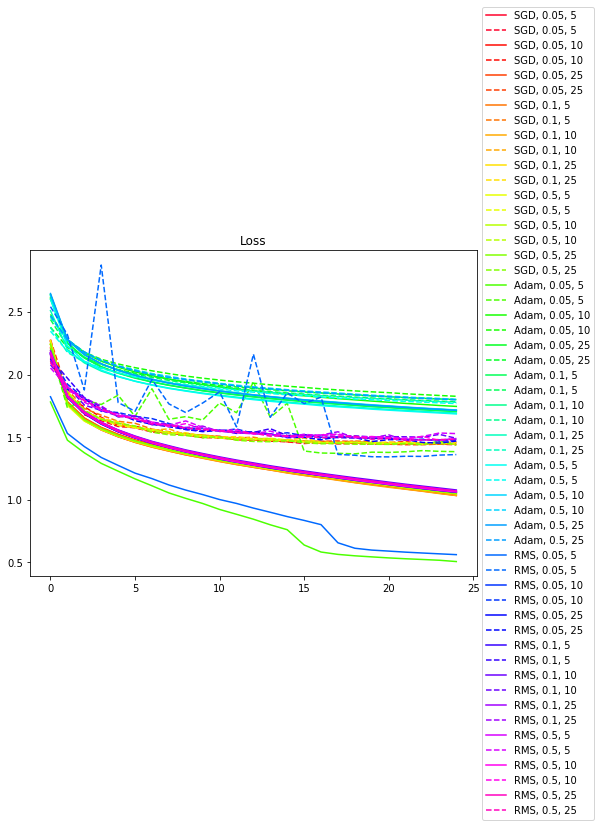

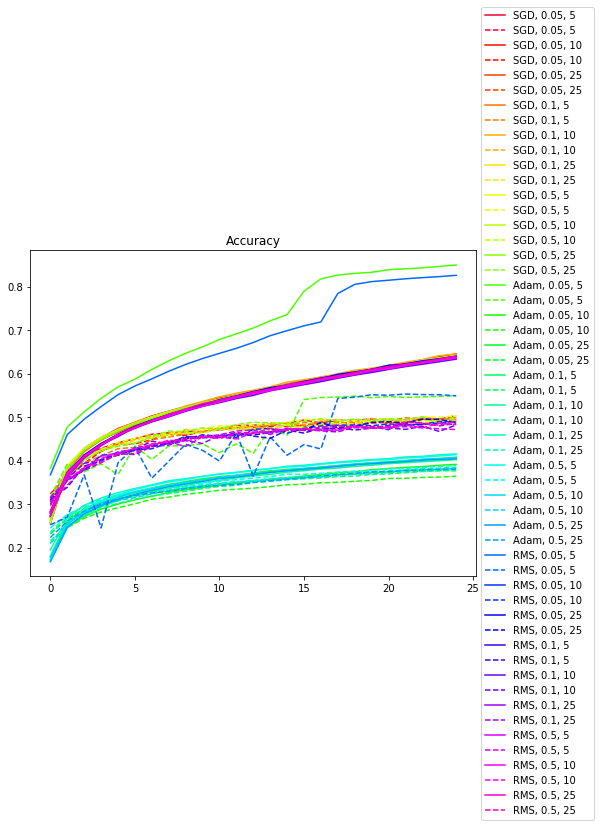

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
Adam不適合用太大的factor去縮減lr
SGD和RMS對於factor的敏感度不高